In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import re
import random
from textblob import TextBlob
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import nltk
from nltk.corpus import stopwords
import string


In [2]:
# topics = [
#     "climate change", "artificial intelligence", "education policy", "healthcare reform", "cryptocurrency",
#     "space exploration", "social media", "global economy", "political debates", "mental health awareness",
#     "renewable energy", "urban development", "privacy laws", "elections", "public transportation",
#     "immigration policy", "technological innovation", "environmental conservation", "food security", "freedom of speech"
# ]

# positive_templates = [
#     "The recent advancements in {topic} have been widely celebrated for their positive societal impact.",
#     "Experts agree that developments in {topic} are opening up exciting opportunities for the future.",
#     "Public reception to the new changes in {topic} has been overwhelmingly supportive and optimistic.",
#     "The policy shift regarding {topic} is being praised as a much-needed and progressive step forward.",
#     "Many believe that {topic} is contributing significantly to a better and more equitable world."
# ]

# negative_templates = [
#     "There is growing concern that current trends in {topic} could lead to serious long-term consequences.",
#     "Critics argue that recent actions in {topic} represent a step backward for societal progress.",
#     "The community has expressed frustration over the recent developments in {topic}.",
#     "Experts are alarmed by the unforeseen consequences stemming from changes in {topic}.",
#     "Opposition voices are growing louder against the recent policies affecting {topic}."
# ]

# neutral_templates = [
#     "The report outlined key metrics and ongoing projects related to {topic} during the last quarter.",
#     "Recent events in {topic} have been documented and presented to the public without much reaction.",
#     "The article summarizes developments in {topic} without expressing any particular viewpoint.",
#     "Ongoing discussions surrounding {topic} have continued with no major changes announced.",
#     "Statistics indicate slight fluctuations in indicators associated with {topic} over the past year."
# ]

# def generate_sentences(templates, label, count):
#     return [
#         (random.choice(templates).format(topic=random.choice(topics)), label)
#         for _ in range(count)
#     ]

# positive_data = generate_sentences(positive_templates, "positive", 4000)
# negative_data = generate_sentences(negative_templates, "negative", 4000)
# neutral_data = generate_sentences(neutral_templates, "neutral", 4000)

# all_data = positive_data + negative_data + neutral_data
# random.shuffle(all_data)

# df = pd.read_csv("sentiment_analysis_data.csv")
# df['sentence'] = all_data
# df.to_csv("unique_balanced_sentiment_data.csv", index=False)


In [3]:
df1=pd.read_csv("train_df.csv")
df2 = pd.read_csv("test_df.csv")
df = pd.concat([df1, df2])
df.head(10)

,id,text,label,sentiment
0,9536,"Cooking microwave pizzas, yummy",2,positive
1,6135,Any plans of allowing sub tasks to show up in ...,1,neutral
2,17697,"I love the humor, I just reworded it. Like sa...",2,positive
3,14182,naw idk what ur talkin about,1,neutral
4,17840,That sucks to hear. I hate days like that,0,negative
5,3655,Umm yeah. That`s probably a pretty good note ...,2,positive
6,719,whatever do you mean?,1,neutral
7,22823,That would panic me a little! Maybe you can ...,0,negative
8,4869,Is sad when people`s phones are dead,0,negative
9,793,sad face.,0,negative


Cleaning


In [4]:
#drop rows with missing sentences
df = df.dropna(subset=['text']).copy()

In [5]:
#cleaning the sentences
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www.\S+", "", text)
    text = re.sub(r"@\w+|#\w+", "", text)
    text = re.sub(r"[^\w\s]", "", text)
    text = re.sub(r"\d+", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

In [6]:
# saving the clean text
df['text'] = df['text'].apply(clean_text)

In [7]:
# date formation
# df['date'] = pd.to_datetime(df['date'], errors='coerce').dt.strftime('%Y-%m-%d')

In [8]:
df.head()

,id,text,label,sentiment
0,9536,cooking microwave pizzas yummy,2,positive
1,6135,any plans of allowing sub tasks to show up in ...,1,neutral
2,17697,i love the humor i just reworded it like sayin...,2,positive
3,14182,naw idk what ur talkin about,1,neutral
4,17840,that sucks to hear i hate days like that,0,negative


In [9]:
df.isnull().sum()

id           0
text         0
label        0
sentiment    0
dtype: int64

In [10]:
# Download stopwords once
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
def remove_stopwords_nltk(text):
    text = text.lower()  # lowercase
    text = text.translate(str.maketrans('', '', string.punctuation))  # remove punctuation
    words = text.split()
    filtered = [word for word in words if word not in stop_words]
    return ' '.join(filtered)


In [12]:
df['clean_sentence'] = df['text'].apply(remove_stopwords_nltk)

In [13]:
from nltk.stem import PorterStemmer
import string

stemmer = PorterStemmer()

def stem_only(text):
    # Lowercase & remove punctuation
    text = text.lower().translate(str.maketrans('', '', string.punctuation))
    
    # Tokenize and stem each word
    words = text.split()
    stemmed = [stemmer.stem(word) for word in words]
    
    return ' '.join(stemmed)


In [14]:
df['clean_sentence'] = df['clean_sentence'].apply(stem_only)
df

,id,text,label,sentiment,clean_sentence
0,9536,cooking microwave pizzas yummy,2,positive,cook microwav pizza yummi
1,6135,any plans of allowing sub tasks to show up in ...,1,neutral,plan allow sub task show widget
2,17697,i love the humor i just reworded it like sayin...,2,positive,love humor reword like say group therapi inste...
3,14182,naw idk what ur talkin about,1,neutral,naw idk ur talkin
4,17840,that sucks to hear i hate days like that,0,negative,suck hear hate day like
...,...,...,...,...,...
5201,10277,fuck no internet damn time warner,0,negative,fuck internet damn time warner
5202,8610,looking forward to android being pushed to the...,1,neutral,look forward android push g
5203,8114,not good wasted time,0,negative,good wast time
5204,3034,u were great as always but cant we do an east ...,2,positive,u great alway cant east germani noko least pro...


In [15]:
# # Define function to label sentiment
# def get_sentiment(text):
#     polarity = TextBlob(text).sentiment.polarity
#     if polarity > 0.05:
#         return 'positive'
#     elif polarity < -0.05:
#         return 'negative'
#     else:
#         return 'neutral'

# # Apply the function to the sentence column
# df['sentiment'] = df['text'].apply(get_sentiment)

# # Preview first few labeled rows
# df.head()


Visualization

In [16]:
df['text'][10]

10    in cafe management the end of the month is not...
10                 but but it was funny when i wrote it
Name: text, dtype: object

In [17]:
df.head(11)

,id,text,label,sentiment,clean_sentence
0,9536,cooking microwave pizzas yummy,2,positive,cook microwav pizza yummi
1,6135,any plans of allowing sub tasks to show up in ...,1,neutral,plan allow sub task show widget
2,17697,i love the humor i just reworded it like sayin...,2,positive,love humor reword like say group therapi inste...
3,14182,naw idk what ur talkin about,1,neutral,naw idk ur talkin
4,17840,that sucks to hear i hate days like that,0,negative,suck hear hate day like
5,3655,umm yeah thats probably a pretty good note to ...,2,positive,umm yeah that probabl pretti good note self ee...
6,719,whatever do you mean,1,neutral,whatev mean
7,22823,that would panic me a little maybe you can rea...,0,negative,would panic littl mayb read orbitron gym like ...
8,4869,is sad when peoples phones are dead,0,negative,sad peopl phone dead
9,793,sad face,0,negative,sad face


C:\Users\user\AppData\Local\Temp\ipykernel_1540\577153967.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment', data=df, palette='coolwarm')


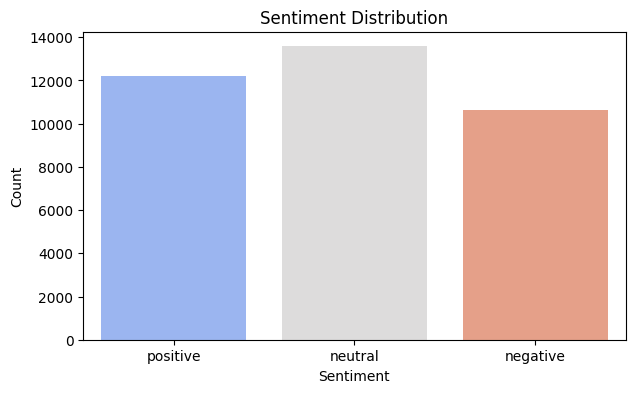

In [18]:
# sentimental distribution
plt.figure(figsize=(7, 4))
sns.countplot(x='sentiment', data=df, palette='coolwarm')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

In [19]:
# #platform distribution
# plt.figure(figsize=(7, 4))
# sns.countplot(x='source', data=df, palette='Set2')
# plt.title('Source Distribution')
# plt.xlabel('Source')
# plt.ylabel('Count')
# plt.show()

In [20]:
# #sentiment by platform
# plt.figure(figsize=(8, 5))
# sns.countplot(x='source', hue='sentiment', data=df, palette='cool')
# plt.title('Sentiment by Platform')
# plt.xlabel('Source')
# plt.ylabel('Count')
# plt.legend(title='Sentiment')
# plt.show()


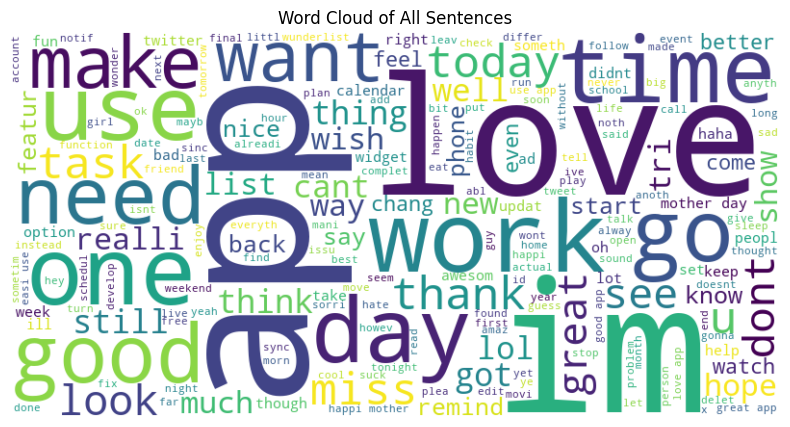

In [21]:
# All sentences
text = ' '.join(df['clean_sentence'].dropna())

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of All Sentences')
plt.show()


In [22]:
# #heatmap of sentiment vs platform 
# # Create pivot table: counts of sentiment per platform
# pivot = pd.crosstab(df['source'], df['sentiment'])

# # Plot heatmap
# plt.figure(figsize=(6,4))
# sns.heatmap(pivot, annot=True, fmt='d', cmap='YlGnBu')
# plt.title("Sentiment Distribution by Platform")
# plt.xlabel("Sentiment")
# plt.ylabel("Platform")
# plt.show()


In [32]:
# Vectorize with TF-IDF (unigrams + bigrams)
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X= vectorizer.fit_transform(df['clean_sentence'])
# y = df['label']

In [33]:
#encoding
le = LabelEncoder()
y = le.fit_transform(df['sentiment'])

In [34]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [35]:
# Define models with fixed/simple params (no tuning)
models = {
    'Logistic Regression': LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced'),
    'Linear SVM': LinearSVC(random_state=42, max_iter=5000, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
}

results = {}

for name, model in models.items():
    print(f"\nTraining and evaluating {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"{name} Test Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred, target_names=le.classes_))
    results[name] = acc

# Compare results
best_model_name = max(results, key=results.get)
print(f"\nBest model based on test accuracy: {best_model_name} with accuracy {results[best_model_name]:.4f}")


Training and evaluating Logistic Regression...
Logistic Regression Test Accuracy: 0.6796
              precision    recall  f1-score   support

    negative       0.66      0.68      0.67      2130
     neutral       0.63      0.62      0.63      2716
    positive       0.75      0.74      0.74      2442

    accuracy                           0.68      7288
   macro avg       0.68      0.68      0.68      7288
weighted avg       0.68      0.68      0.68      7288


Training and evaluating Linear SVM...
Linear SVM Test Accuracy: 0.6645
              precision    recall  f1-score   support

    negative       0.66      0.65      0.66      2130
     neutral       0.61      0.62      0.62      2716
    positive       0.73      0.72      0.73      2442

    accuracy                           0.66      7288
   macro avg       0.67      0.67      0.67      7288
weighted avg       0.66      0.66      0.66      7288


Training and evaluating Random Forest...
Random Forest Test Accuracy: 0.676

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [01:48:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Test Accuracy: 0.6670
              precision    recall  f1-score   support

    negative       0.73      0.54      0.62      2130
     neutral       0.58      0.73      0.65      2716
    positive       0.75      0.71      0.73      2442

    accuracy                           0.67      7288
   macro avg       0.69      0.66      0.66      7288
weighted avg       0.68      0.67      0.67      7288


Best model based on test accuracy: Logistic Regression with accuracy 0.6796


In [36]:
best_model = models[best_model_name]

# Example prediction on new input
new_texts = ["The movie was awesome!", "I didn't like the product.", "It’s okay, nothing special."]
new_vec = vectorizer.transform(new_texts)
preds = best_model.predict(new_vec)

# Convert numeric predictions to original labels
pred_labels = le.inverse_transform(preds)
print(pred_labels)


['neutral' 'positive' 'positive']


In [37]:
import joblib

joblib.dump(best_model, "sentiment_model.pkl")
joblib.dump(vectorizer, "vectorizer.pkl")
joblib.dump(le, "label_encoder.pkl")


['label_encoder.pkl']

In [41]:
def predict_sentiment(text):
    X = vectorizer.transform([text])
    pred_idx = best_model.predict(X)[0]
    sentiment = le.inverse_transform([pred_idx])[0]
    return sentiment


In [44]:
print(predict_sentiment("I love this product!"))  # Should print 'positive' or whatever label you have
print(predict_sentiment("This is the worst!"))
print(predict_sentiment("Not bad, but could be better."))
print(predict_sentiment("The meeting is scheduled for Tuesday at 10 AM."))

positive
negative
negative
neutral
